In [1]:
import torch

In [2]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import special as sc
from torch.autograd import Variable


# Define the desired types
rtype = torch.float32
ctype = torch.complex64

# Create tensors with single precision
t0 = torch.tensor(0.0, dtype=rtype)           # initial time
t1 = torch.tensor(np.pi, dtype=rtype)        # final time
xl = torch.tensor(0.0, dtype=rtype)           # left domain boundary
xr = torch.tensor(8.0, dtype=rtype)           # right domain boundary
hbar = torch.tensor(1.0, dtype=rtype)         # physical constant
mass = torch.tensor(1.0, dtype=rtype)         # physical constant

# Cast to complex type if needed
chbar = hbar.to(ctype)
cmass = mass.to(ctype)


# define plane wave
def psi(x, t):
    return sine_wave(x, t)

# Plane wave function
def plane_wave(x, t):
    k = 1.0
    omega = 0.5 / mass * k**2
    re = torch.cos(k * x - omega * t)
    im = torch.sin(k * x - omega * t)
    return torch.stack([re, im], dim=-1)

# Gaussian wave packet
def gaussian(x, t):
    xc = 0.5          # center of wave packet
    alpha = 0.01      # width of wave packet
    cx = x.to(ctype)
    ct = t.to(ctype)
    psi = torch.sqrt(1 / (alpha + 1j * ct * chbar / cmass)) * torch.exp(
        -((cx - xc) ** 2) / (2 * (alpha + 1j * ct * chbar / cmass))
    )
    return torch.cat([torch.real(psi), torch.imag(psi)], dim=-1)

# Moving Gaussian wave packet
def moving_gaussian(x, t):
    xc = torch.tensor(0.5, dtype=ctype)           # center of wave packet
    alpha = torch.tensor(1.0 / 100, dtype=ctype)   # width of wave packet
    k = 1.0
    s = 0.1
    cx = x.to(ctype)
    ct = t.to(ctype)
    s2 = s**2
    psi = torch.exp(-0.25 * (cx - xc - 2j * k * s2)**2 / (s2 + 1j * ct))
    psi *= torch.exp(1j * k * xc - k**2 * s2) / torch.sqrt(s2 + 1j * ct)
    psi *= (0.5 * s2 / np.pi)**0.25
    return torch.stack([torch.real(psi), torch.imag(psi)], dim=-1)

# Li2 wave function using Fresnel integrals
# def li2(x, t, A=torch.sqrt(5) - torch.sqrt(6), B=torch.sqrt(6)):
#     x0 = 0  # You may need to define x0 if it’s not provided elsewhere
#     C, S = sc.fresnel((x - x0) * torch.sqrt(1 / (np.pi * t * hbar / mass)))
#     psi = A / 2 + B - A / 2 * (1 + 1j) * C - A / 2 * (1 - 1j) * S
#     return psi

# Initial Periodic Sine Wave function
def sine_wave(x, t):
    re = (1.0 + 0.6 * torch.sin(np.pi * x / 4)) ** 0.5
    im = torch.zeros_like(x)
    return torch.cat([re, im], dim=1)

# Density and real/imaginary part functions
def get_density(psi):
    return torch.square(psi[:, 0]) + torch.square(psi[:, 1])

def get_real(psi):
    return psi[:, 0]

def get_imag(psi):
    return psi[:, 1]




# Parameters for sampling
n_initial = 10000
n_boundary = 10000
n_collocation = 20000

# Draw initial data at t0 from uniform distribution
t_initial = Variable(torch.ones((n_initial, 1), dtype=rtype) * t0,requires_grad = False)
x_initial = Variable(torch.rand((n_initial, 1), dtype=rtype) * (xr - xl) + xl,requires_grad = False)
xt_initial = torch.cat([x_initial, t_initial], dim=1)
psi_initial = psi(x_initial, t_initial)
psi_re_0 = Variable(get_real(psi_initial),requires_grad = False)
psi_im_0 = Variable(get_imag(psi_initial),requires_grad = False)

# Draw boundary data from uniform distributions for t and x
t_boundary = Variable(torch.rand((n_boundary, 1), dtype=rtype) * (t1 - t0) + t0,requires_grad = False)

# Map to left and right boundary via a Bernoulli distribution
boundary_choice = torch.bernoulli(torch.rand((n_boundary, 1)))
x_boundary = xl + (xr - xl) * boundary_choice
xt_boundary = torch.cat([x_boundary, t_boundary], dim=1)
psi_boundary = psi(x_boundary, t_boundary)

xl_boundary = Variable(torch.ones((n_boundary,1),dtype = rtype)*xl,requires_grad=True)
xlt_boundary = Variable(torch.cat([xl_boundary,t_boundary],axis = 1),requires_grad = True)
xr_boundary = Variable(torch.ones((n_boundary,1),dtype = rtype)*xr,requires_grad = True)
xrt_boundary = Variable(torch.cat([xr_boundary,t_boundary],axis = 1),requires_grad = True)


# Draw collocation points from uniform distribution
t_collocation = Variable(torch.rand((n_collocation, 1), dtype=rtype) * (t1 - t0) + t0,requires_grad=True)
x_collocation = Variable(torch.rand((n_collocation, 1), dtype=rtype) * (xr - xl) + xl,requires_grad= True)
xt_collocation = Variable(torch.cat([x_collocation, t_collocation], dim=1),requires_grad = True)


/opt/python/3.9.4.1/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [5]:
print(t_collocation.shape)

torch.Size([20000, 1])


tensor(1000.)


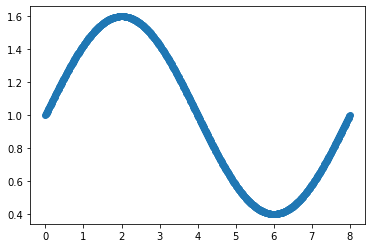

In [33]:
xrt_boundary.shape, xlt_boundary.shape

x_c = torch.linspace(0.,8.,1000)
dx = x_c[1]-x_c[0]

dx

np.ones((100))*0.0

psi_c = psi(x_c.reshape(1000,1),torch.ones((1000,1))*0.0)

den_c = get_density(psi_c)

plt.scatter(x_c,den_c)

print(torch.sum(den_c))

def integral(x, y):
    """
    Calculates the integral of y with respect to x over the interval [a, b] using cumulative sums.

    Parameters:
    x (array-like): The x values (independent variable), should be evenly spaced.
    y (array-like): The y values (dependent variable) to integrate.

    Returns:
    float: The integral of y with respect to x over [a, b].
    """
    # Calculate the differences in x
    dx = jnp.diff(x)
    # Apply the trapezoidal rule to get the integral
    integral = jnp.sum((y[:-1] + y[1:]) / 2 * dx)

    return integral

#integral(den_c,x_c)



**Visualize initial and boundary data**


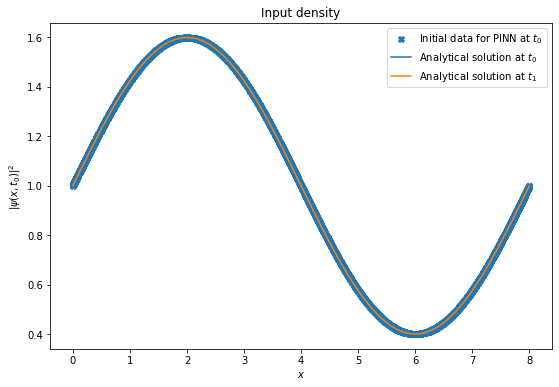

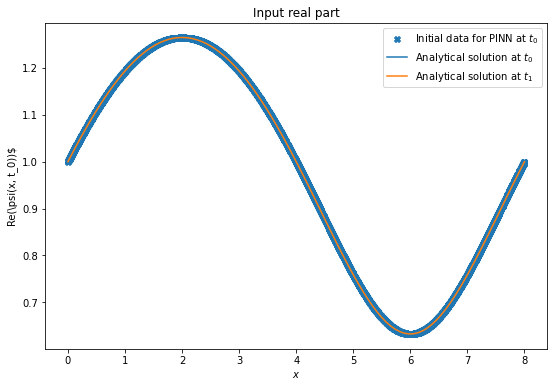

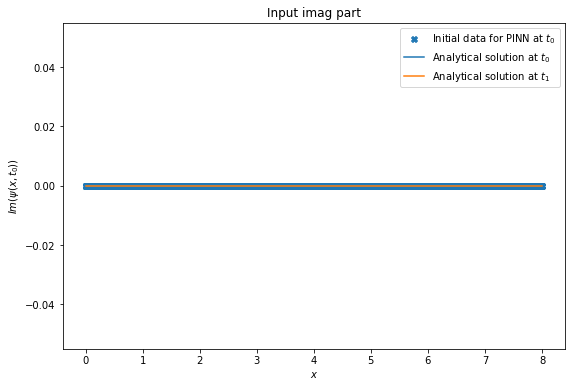

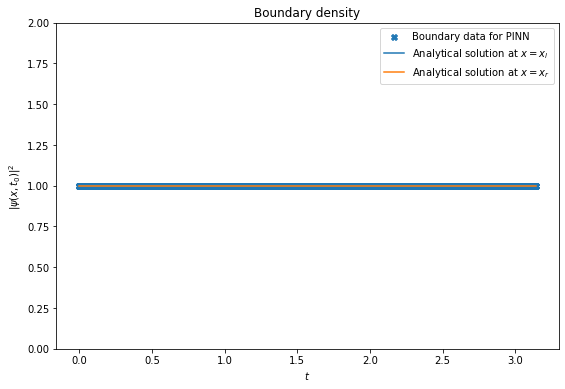

In [34]:

import matplotlib.pyplot as plt

n_linear     = 100
# Make sure that input times and positions are tensors of shape (n, 1) because that is what psi expects
xl_linear    = torch.ones((n_linear, 1)) * xl
xr_linear    = torch.ones((n_linear, 1)) * xr
t0_linear    = torch.ones((n_linear, 1)) * t0
t1_linear    = torch.ones((n_linear, 1)) * t1
x_linear     = torch.reshape(torch.linspace(xl, xr, n_linear), (n_linear, 1))
t_linear     = torch.reshape(torch.linspace(t0, t1, n_linear), (n_linear, 1))
# Reference for initial conditions
psi_0_linear = psi(x_linear, t0_linear)
psi_1_linear = psi(x_linear, t1_linear)
# Reference for boundary conditions
psi_l_linear = psi(xl_linear, t_linear)
psi_r_linear = psi(xr_linear, t_linear)



fig = plt.figure(figsize=(9,6))
plt.title('Input density')
plt.scatter(x_initial, get_density(psi_initial),  marker='X', label="Initial data for PINN at $t_0$")
plt.plot(x_linear, get_density(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.plot(x_linear, get_density(psi_1_linear), label=r"Analytical solution at $t_1$")
#plt.ylim(0, 2)
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Input real part')
plt.scatter(x_initial, get_real(psi_initial),  marker='X', label="Initial data for PINN at $t_0$")
plt.plot(x_linear, get_real(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.plot(x_linear, get_real(psi_1_linear), label=r"Analytical solution at $t_1$")
plt.xlabel('$x$')
plt.ylabel('Re(\psi(x, t_0))$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Input imag part')
plt.scatter(x_initial, get_imag(psi_initial),  marker='X', label="Initial data for PINN at $t_0$")
plt.plot(x_linear, get_imag(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.plot(x_linear, get_imag(psi_1_linear), label=r"Analytical solution at $t_1$")
plt.xlabel('$x$')
plt.ylabel('$Im(\psi(x, t_0))$')#
plt.legend()
plt.show()
plt.close()


fig = plt.figure(figsize=(9,6))
plt.title('Boundary density')
plt.scatter(t_boundary, get_density(psi_boundary),  marker='X', label="Boundary data for PINN")
plt.plot(t_linear, get_density(psi_l_linear), label=r"Analytical solution at $x=x_l$")
plt.plot(t_linear, get_density(psi_r_linear), label=r"Analytical solution at $x=x_r$")
plt.ylim(0, 2)
plt.xlabel('$t$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

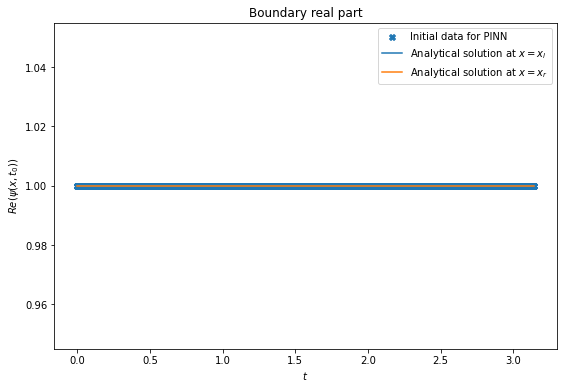

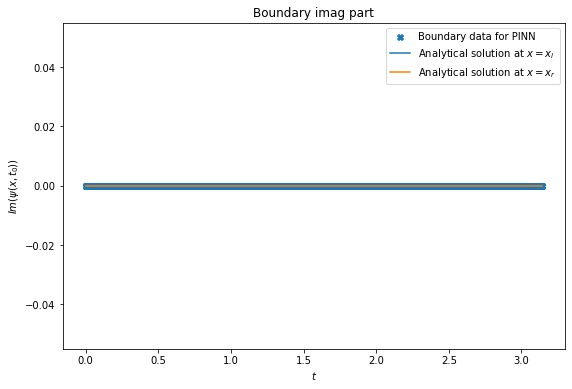

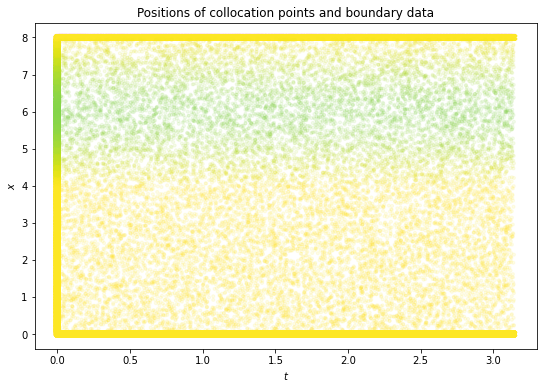

In [35]:
fig = plt.figure(figsize=(9,6))
plt.title('Boundary real part')
plt.scatter(t_boundary, get_real(psi_boundary),  marker='X', label="Initial data for PINN")
plt.plot(t_linear, get_real(psi_l_linear), label=r"Analytical solution at $x=x_l$")
plt.plot(t_linear, get_real(psi_r_linear), label=r"Analytical solution at $x=x_r$")
plt.xlabel('$t$')
plt.ylabel('$Re(\psi(x, t_0))$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Boundary imag part')
plt.scatter(t_boundary, get_imag(psi_boundary),  marker='X', label="Boundary data for PINN")
plt.plot(t_linear, get_imag(psi_l_linear), label=r"Analytical solution at $x=x_l$")
plt.plot(t_linear, get_imag(psi_r_linear), label=r"Analytical solution at $x=x_r$")
plt.xlabel('$t$')
plt.ylabel('$Im(\psi(x, t_0))$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Positions of collocation points and boundary data')
plt.scatter(t_initial,     x_initial,     c=get_real(psi_initial),  marker='X', vmin=-1, vmax=1)
plt.scatter(t_boundary,    x_boundary,    c=get_real(psi_boundary), marker='X', vmin=-1, vmax=1)
plt.scatter(t_collocation.detach().numpy(), x_collocation.detach().numpy(), c=get_real(psi(x_collocation, t_collocation)).detach().numpy(), vmin=-1, vmax=1, marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

**Neural Newtwork Architecture**

In [36]:



class Sin(nn.Module):
    def forward(self, input):
        return torch.sin(input)
class Sin_s(nn.Module):
    def forward(self, input):
        return input*torch.sin(input)

class PINNs(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
        super(PINNs, self).__init__()


        layers = []
        for i in range(num_layer-1):
            if i == 0:
                layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
                layers.append(Sin())
                # layers.append(torch.sin(layers))
            else:
                layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
                layers.append(Sin())

        layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))
        #layers.append(Sin_s())#nn.SiLU())

        self.linear = nn.Sequential(*layers)

    def forward(self, x, t):
        src = torch.cat((x,t), dim=-1)
        return self.linear(src)


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

net = PINNs(in_dim=2, hidden_dim=32, out_dim=3, num_layer=3)
net.apply(init_weights) ## This is optional
print(net)

mse_cost_function = torch.nn.MSELoss() # Mean squared error
mae_cost_function = torch.nn.L1Loss() # Mean absolute error
optimizer = torch.optim.Adam(net.parameters(),lr=0.001,)
optimizerL = torch.optim.LBFGS(net.parameters(),line_search_fn='strong_wolfe')

######### Boundary Conditions ##########

def get_boundary_rho_vel_phi(x_bc_l,x_bc_r,t,net):

    '''
    Estimate the loss at the boundary
    Input: The collocation points at the boundary
           PINN network/model
           Time domain for the time dependent PDEs

    Output:The loss for each of the boudary values
    '''


    re_l, im_l, V_l = net(x_bc_l,t)[:,0:1], net(x_bc_l,t)[:,1:2], net(x_bc_l,t)[:,2:3]
    re_r, im_r, V_r = net(x_bc_r,t)[:,0:1], net(x_bc_r,t)[:,1:2], net(x_bc_r,t)[:,2:3]


    V_l_x = torch.autograd.grad(V_l, x_bc_l,grad_outputs=torch.ones_like(V_l), create_graph=True)[0]
    V_r_x = torch.autograd.grad(V_r, x_bc_r,grad_outputs=torch.ones_like(V_r), create_graph=True)[0]

    re_l_x = torch.autograd.grad(re_l, x_bc_l,grad_outputs=torch.ones_like(re_l), create_graph=True)[0]
    re_r_x = torch.autograd.grad(re_r, x_bc_r,grad_outputs=torch.ones_like(re_r), create_graph=True)[0]

    im_l_x = torch.autograd.grad(im_l, x_bc_l,grad_outputs=torch.ones_like(im_l), create_graph=True)[0]
    im_r_x = torch.autograd.grad(im_r, x_bc_r,grad_outputs=torch.ones_like(im_r), create_graph=True)[0]

    
    re_b    = re_l - re_r
    re_x_b = re_l_x - re_r_x
    im_b      = im_l - im_r
    im_x_b = im_l_x - im_r_x
    V_b    = V_l - V_r
    V_x_b  = V_l_x - V_r_x


    return re_b, im_b, V_b , V_x_b, re_x_b, im_x_b





######### Residue from the PDEs##########

def pde_residue(x,t,net):

    '''
    This is the main function that returns all the PDE residue
    INPUT: x and t collocation points for the 1D problem
    OUTPUT: The output dimension is 3, one of density, one for velocity and finally for phi
    '''

    net_outputs = net(x,t)

    re, im, V = net_outputs[:,0:1], net_outputs[:,1:2], net_outputs[:,2:3]

    ## Derivatives for the Equations:
    re_x = torch.autograd.grad(re, x,grad_outputs=torch.ones_like(re), create_graph=True)[0]
    re_xx = torch.autograd.grad(re_x, x,grad_outputs=torch.ones_like(re_x), create_graph=True)[0]
    re_t = torch.autograd.grad(re, t,grad_outputs=torch.ones_like(re),create_graph=True)[0]

    im_x = torch.autograd.grad(im, x,grad_outputs=torch.ones_like(im), create_graph=True)[0]
    im_xx = torch.autograd.grad(im_x, x,grad_outputs=torch.ones_like(im_x), create_graph=True)[0]
    im_t = torch.autograd.grad(im, t,grad_outputs=torch.ones_like(im), create_graph=True)[0]

    V_x = torch.autograd.grad(V, x,grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_xx = torch.autograd.grad(V_x, x,grad_outputs=torch.ones_like(V_x), create_graph=True)[0]

    #     j = re*im_x - im * re_x
    #     j_x = torch.autograd.grad(j,x,grad_outputs = torch.ones_like(j), create_graph = True)[0]

    #     rho = re**2 + im**2
    #     rho_t = torch.autograd.grad(rho,t,grad_outputs = torch.ones_like(rho), create_graph = True)[0]

    ## The residues from the equations
    re_r = re_t + 0.5 * im_xx - V * im 
    im_r = im_t - 0.5 * re_xx + V * re 
    V_r = V_xx -((re**2+im**2)-1.0)
    #rho_r = 2*(re*re_t+im*im_t) +(re*im_xx-im*re_xx)
    return re_r,im_r,V_r#,rho_r


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Sin()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sin()
    (4): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [14]:
psi_re_0.shape

torch.Size([10000])

In [15]:
x_initial

tensor([[1.2720],
        [2.9100],
        [4.1063],
        ...,
        [3.5649],
        [3.6092],
        [2.6512]])

In [16]:
torch.sum(psi_re_0**2+psi_im_0**2)*x_collocatio

NameError: name 'x_collocatio' is not defined

In [ ]:
net(x_initial, t_initial)[:,0:1].flatten().shape

In [ ]:
from tqdm import tqdm
import time

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
iterations = 200
start = time.time()
def closure():

        ############## Loss based on initial conditions ###############

        net_ic_out = net(x_initial, t_initial) # output of rho(x,t=0), vel(x,t=0)

        re_ic_out = net_ic_out[:,0:1]
        im_ic_out = net_ic_out[:,1:2]

        mse_re_ic =  mse_cost_function(re_ic_out.flatten(), psi_re_0)#get_real(psi(x_initial,t_initial)))
        mse_im_ic =  mse_cost_function(im_ic_out.flatten(), psi_im_0)#get_imag(psi(x_initial,t_initial)))

        ############# Loss based on boundary conditions #################

        re_b, im_b, V_b, V_x_b, re_x_b, im_x_b = get_boundary_rho_vel_phi(xl_boundary,xr_boundary,t_boundary,net) # output of u(x,t)


        mse_bc_re = torch.mean(re_b ** 2) ## mse_cost_function(rho_bc_out,pt_all_zeros_bc)
        mse_bc_im = torch.mean(im_b ** 2) ## mse_cost_function(vel_bc_out,pt_all_zeros_bc)
        mse_bc_V = torch.mean(V_b ** 2) ## mse_cost_function(vel_bc_out,pt_all_zeros_bc)
        mse_bc_V_x = torch.mean(V_x_b ** 2) ## mse_cost_function(vel_bc_out,pt_all_zeros_bc)
        mse_bc_re_x = torch.mean(re_x_b ** 2)
        mse_bc_im_x = torch.mean(im_x_b ** 2)
        ############## Loss based on PDE ###################################

        re_r,im_r,V_r = pde_residue(x_collocation, t_collocation, net) # output of rho(x,t) and vel(x,t)


        mse_re = torch.mean(re_r ** 2)  ##mse_cost_function(rho_pde_out, pt_all_zeros)
        mse_im = torch.mean(im_r ** 2)  ## mse_cost_function(vel_pde_out, pt_all_zeros)
        mse_V = torch.mean(V_r ** 2)  ## mse_cost_function(vel_pde_out, pt_all_zeros)
        #mse_rho = torch.mean(rho_r ** 2)

        ################### Combining the loss functions ####################
        loss = mse_re_ic + mse_im_ic + mse_re + mse_im + mse_V + mse_bc_re+ mse_bc_im + mse_bc_V+ mse_bc_V_x + mse_bc_re_x + mse_bc_im_x
        ################### Combining the loss functions ####################
        # Stack all loss terms
        #         loss_terms = torch.stack([
        #             mse_re_ic, mse_im_ic, mse_re, mse_im, mse_V,
        #             mse_bc_re, mse_bc_im, mse_bc_V, mse_bc_V_x
        #         ])

        #         # Normalize weights using softmax to ensure they sum to 1
        #         normalized_weights = torch.nn.functional.softmax(loss_weights, dim=0)

        #         # Compute weighted loss
        #         loss = torch.sum(normalized_weights * loss_terms)

        optimizerL.zero_grad()
        loss.backward() # This is for computing gradients using backward propagationerivative of J w.r.t theta
        return loss
TOTAL_loss = []

# ## Using ADAM

for i in tqdm(range(5*iterations)):
    loss_ = optimizer.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
print("INFO:Adam training done LBFGS initiated")
## Using LBFGS after the initial ADAM training
# for i in tqdm(range(iterations*3)):
#     loss_ = optimizerL.step(closure)
#     TOTAL_loss.append(loss_.item())
#     if i % 50 == 0:
#         print("TOTAL LOSS ={:.2e}".format(loss_.item()))
# end = time.time()
# print("Total time = {} sec ".format(end - start))

# torch.save(net.state_dict(), 'PINN3.pt')


  0%|          | 4/1000 [00:00<01:05, 15.27it/s]

TOTAL LOSS =3.11e+00


  5%|▌         | 54/1000 [00:03<00:57, 16.33it/s]

TOTAL LOSS =1.78e-01


 10%|█         | 104/1000 [00:06<00:55, 16.21it/s]

TOTAL LOSS =5.63e-02


 15%|█▌        | 154/1000 [00:09<00:52, 16.23it/s]

TOTAL LOSS =4.01e-02


 20%|██        | 204/1000 [00:12<00:49, 16.24it/s]

TOTAL LOSS =3.51e-02


 25%|██▌       | 254/1000 [00:15<00:46, 16.20it/s]

TOTAL LOSS =3.27e-02


 30%|███       | 304/1000 [00:18<00:43, 16.13it/s]

TOTAL LOSS =3.09e-02


 35%|███▌      | 354/1000 [00:21<00:40, 16.03it/s]

TOTAL LOSS =2.94e-02


 40%|████      | 404/1000 [00:25<00:36, 16.13it/s]

TOTAL LOSS =2.82e-02


 45%|████▌     | 454/1000 [00:28<00:36, 15.05it/s]

TOTAL LOSS =2.72e-02


 50%|█████     | 504/1000 [00:31<00:30, 16.20it/s]

TOTAL LOSS =2.64e-02


 55%|█████▌    | 554/1000 [00:34<00:27, 16.16it/s]

TOTAL LOSS =2.56e-02


 60%|██████    | 604/1000 [00:37<00:24, 16.23it/s]

TOTAL LOSS =2.50e-02


 65%|██████▌   | 654/1000 [00:40<00:21, 16.18it/s]

TOTAL LOSS =2.44e-02


 70%|███████   | 704/1000 [00:43<00:18, 16.26it/s]

TOTAL LOSS =2.38e-02


 75%|███████▌  | 754/1000 [00:46<00:15, 16.15it/s]

TOTAL LOSS =2.33e-02


 80%|████████  | 804/1000 [00:49<00:12, 16.22it/s]

TOTAL LOSS =2.28e-02


 85%|████████▌ | 854/1000 [00:53<00:09, 16.14it/s]

TOTAL LOSS =2.23e-02


 90%|█████████ | 904/1000 [00:56<00:05, 16.18it/s]

TOTAL LOSS =2.18e-02


 95%|█████████▌| 954/1000 [00:59<00:02, 16.24it/s]

TOTAL LOSS =2.14e-02


100%|██████████| 1000/1000 [01:02<00:00, 16.11it/s]

INFO:Adam training done LBFGS initiated


In [38]:
net.load_state_dict(torch.load('PINN_vbc.pt'))

<All keys matched successfully>

In [18]:
from tqdm import tqdm
import time
## Using LBFGS after the initial ADAM training
for i in tqdm(range(200*3)):
    loss_ = optimizerL.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
end = time.time()
print("Total time = {} sec ".format(end - start))

#torch.save(net.state_dict(), 'PINN3.pt')

  0%|          | 1/600 [00:01<14:19,  1.44s/it]

TOTAL LOSS =2.44e-04


  8%|▊         | 51/600 [01:13<13:08,  1.44s/it]

TOTAL LOSS =1.95e-04


 17%|█▋        | 101/600 [02:25<12:24,  1.49s/it]

TOTAL LOSS =1.59e-04


 25%|██▌       | 151/600 [03:38<10:57,  1.46s/it]

TOTAL LOSS =1.36e-04


 34%|███▎      | 201/600 [04:51<09:20,  1.41s/it]

TOTAL LOSS =1.15e-04


 42%|████▏     | 251/600 [06:02<08:16,  1.42s/it]

TOTAL LOSS =9.94e-05


 50%|█████     | 301/600 [07:14<07:00,  1.41s/it]

TOTAL LOSS =8.92e-05


 58%|█████▊    | 351/600 [08:25<05:53,  1.42s/it]

TOTAL LOSS =7.97e-05


 67%|██████▋   | 401/600 [09:37<04:53,  1.47s/it]

TOTAL LOSS =7.05e-05


 75%|███████▌  | 451/600 [10:48<03:31,  1.42s/it]

TOTAL LOSS =6.38e-05


 84%|████████▎ | 501/600 [11:57<01:57,  1.19s/it]

TOTAL LOSS =5.81e-05


 92%|█████████▏| 551/600 [13:05<01:10,  1.44s/it]

TOTAL LOSS =5.33e-05


100%|██████████| 600/600 [14:10<00:00,  1.42s/it]

Total time = 1711.3381643295288 sec 


In [19]:
from tqdm import tqdm
import time
## Using LBFGS after the initial ADAM training
for i in tqdm(range(200*3)):
    loss_ = optimizerL.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
end = time.time()
print("Total time = {} sec ".format(end - start))

  0%|          | 1/600 [00:01<13:32,  1.36s/it]

TOTAL LOSS =4.98e-05


  8%|▊         | 51/600 [01:05<12:47,  1.40s/it]

TOTAL LOSS =4.63e-05


 17%|█▋        | 101/600 [02:12<09:22,  1.13s/it]

TOTAL LOSS =4.28e-05


 25%|██▌       | 151/600 [03:19<10:14,  1.37s/it]

TOTAL LOSS =3.94e-05


 34%|███▍      | 203/600 [03:52<00:28, 13.95it/s]

TOTAL LOSS =3.81e-05


 42%|████▏     | 253/600 [03:55<00:23, 15.04it/s]

TOTAL LOSS =3.81e-05


 50%|█████     | 303/600 [03:59<00:19, 15.21it/s]

TOTAL LOSS =3.81e-05


 59%|█████▉    | 353/600 [04:02<00:16, 15.34it/s]

TOTAL LOSS =3.81e-05


 67%|██████▋   | 403/600 [04:05<00:12, 15.42it/s]

TOTAL LOSS =3.81e-05


 76%|███████▌  | 453/600 [04:08<00:09, 15.44it/s]

TOTAL LOSS =3.81e-05


 84%|████████▍ | 503/600 [04:12<00:06, 15.35it/s]

TOTAL LOSS =3.81e-05


 92%|█████████▏| 553/600 [04:15<00:03, 15.01it/s]

TOTAL LOSS =3.81e-05


100%|██████████| 600/600 [04:18<00:00,  2.32it/s]

Total time = 1990.7830901145935 sec 


In [36]:
from tqdm import tqdm
import time
## Using LBFGS after the initial ADAM training
for i in tqdm(range(200*3)):
    loss_ = optimizerL.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
end = time.time()
print("Total time = {} sec ".format(end - start))

  0%|          | 2/600 [00:00<00:53, 11.27it/s]

TOTAL LOSS =5.92e-05


  9%|▊         | 52/600 [00:03<00:41, 13.07it/s]

TOTAL LOSS =5.92e-05


 17%|█▋        | 102/600 [00:07<00:37, 13.20it/s]

TOTAL LOSS =5.92e-05


 25%|██▌       | 152/600 [00:11<00:33, 13.21it/s]

TOTAL LOSS =5.92e-05


 34%|███▎      | 202/600 [00:15<00:30, 13.19it/s]

TOTAL LOSS =5.92e-05


 42%|████▏     | 252/600 [00:19<00:26, 13.20it/s]

TOTAL LOSS =5.92e-05


 50%|█████     | 302/600 [00:22<00:22, 13.20it/s]

TOTAL LOSS =5.92e-05


 59%|█████▊    | 352/600 [00:26<00:18, 13.07it/s]

TOTAL LOSS =5.92e-05


 67%|██████▋   | 402/600 [00:30<00:15, 12.90it/s]

TOTAL LOSS =5.92e-05


 75%|███████▌  | 452/600 [00:34<00:11, 13.09it/s]

TOTAL LOSS =5.92e-05


 84%|████████▎ | 502/600 [00:38<00:07, 13.04it/s]

TOTAL LOSS =5.92e-05


 92%|█████████▏| 552/600 [00:42<00:03, 12.81it/s]

TOTAL LOSS =5.92e-05


100%|██████████| 600/600 [00:45<00:00, 13.09it/s]

Total time = 3270.4592139720917 sec 


In [40]:
torch.save(net.state_dict(), 'PINN_vbc.pt')


In [20]:
torch.save(net.state_dict(), 'PINN_correct2.pt')


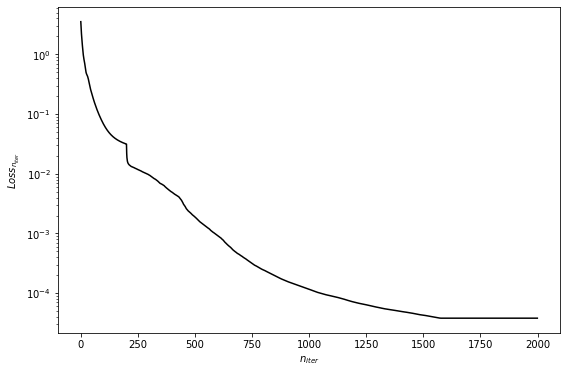

In [21]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
# hist =[] is used for storing losses during training
hist = TOTAL_loss#_history
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{iter}$')
ax.set_ylabel('$Loss_{n_{iter}}$');

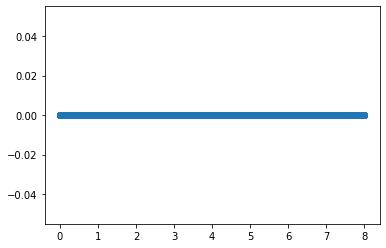

In [54]:
plt.scatter(x_initial,get_imag(psi(x_initial,t_initial)))

1.10.1+cu111


In [ ]:
optimizerL2 = NysNewtonCG(net.parameters())

In [ ]:
## Using LBFGS after the initial ADAM training
for i in tqdm(range(iterations*2)):
    loss_ = optimizerL2.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
end = time.time()
print("Total time = {} sec ".format(end - start))


In [39]:
x_1

tensor([[7.7869],
        [2.4089],
        [4.1914],
        [6.1939],
        [7.7047],
        [4.0582],
        [6.7407],
        [3.7753],
        [2.2560],
        [5.2720],
        [6.6430],
        [4.6771],
        [0.8951],
        [7.5243],
        [6.4329],
        [3.2565],
        [0.7214],
        [2.5700],
        [7.6738],
        [4.7443],
        [0.6133],
        [0.9451],
        [0.2286],
        [3.7710],
        [5.0472],
        [2.5997],
        [4.2305],
        [0.6929],
        [0.3067],
        [5.9704],
        [3.9906],
        [4.4319],
        [1.1318],
        [1.0631],
        [2.6579],
        [3.6262],
        [4.1664],
        [1.8774],
        [0.9605],
        [6.0216],
        [3.4797],
        [1.9552],
        [5.5993],
        [0.4759],
        [4.2717],
        [2.2591],
        [4.4990],
        [0.6662],
        [1.8873],
        [3.7645],
        [6.1276],
        [6.8775],
        [2.8136],
        [5.3514],
        [5.4639],
        [5

In [21]:
print(torch.mean(torch.exp(net(x_initial,t_initial*0)[:,0]-get_real(psi(x_initial,t_initial)))))

tensor(1.0490, grad_fn=<MeanBackward0>)


tensor(10068.5244, grad_fn=<SumBackward0>)
tensor(10017.6367, grad_fn=<SumBackward0>)
tensor(10065.4648, grad_fn=<SumBackward0>)
tensor(10037.5996, grad_fn=<SumBackward0>)
tensor(9973.1729, grad_fn=<SumBackward0>)
tensor(9986.4248, grad_fn=<SumBackward0>)
tensor(10086.3535, grad_fn=<SumBackward0>)
tensor(10037.8643, grad_fn=<SumBackward0>)
tensor(10146.6094, grad_fn=<SumBackward0>)
tensor(9933.7139, grad_fn=<SumBackward0>)
tensor(10189.0029, grad_fn=<SumBackward0>)
tensor(10047.7900, grad_fn=<SumBackward0>)
tensor(10059.6953, grad_fn=<SumBackward0>)
tensor(10049.9355, grad_fn=<SumBackward0>)
tensor(9974.0576, grad_fn=<SumBackward0>)
tensor(10154.5723, grad_fn=<SumBackward0>)
tensor(10105.1016, grad_fn=<SumBackward0>)
tensor(10283.6553, grad_fn=<SumBackward0>)
tensor(9859.4941, grad_fn=<SumBackward0>)
tensor(10077.7344, grad_fn=<SumBackward0>)
tensor(10185.7891, grad_fn=<SumBackward0>)


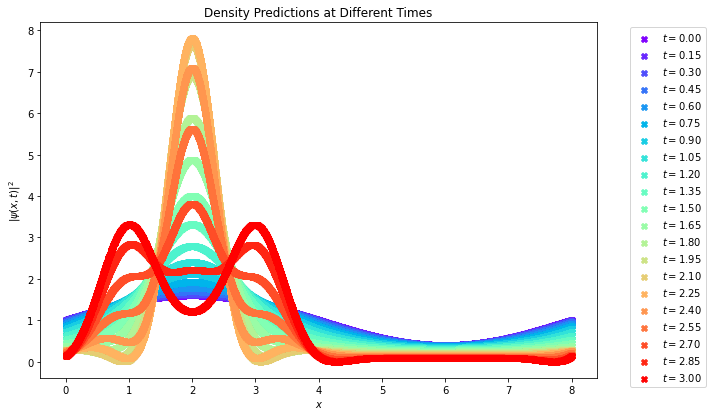

In [22]:
#model = score_model_cond()
#net.load_state_dict(torch.load('PINN2.pt'))

# Define the time points we want to plot
time_indices = [i / 100 for i in range(0,314, 15)]  # Time points to visualize

# Set up the figure
fig = plt.figure(figsize=(10, 6))
plt.title('Density Predictions at Different Times')
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t)|^2$')

# Use a colormap for the rainbow effect
cmap = plt.cm.rainbow
colors = cmap(np.linspace(0, 1, len(time_indices)))

# Loop over selected time points and plot each density profile
for idx, color in zip(time_indices, colors):
    # Update time value for current plot
    t_1 = torch.ones((10000, 1)) * idx
    x_1 = torch.rand((10000, 1)) * (8.0 - 0.0)  # Adjust xl and xr as needed
    xt_1 = torch.cat([x_1, t_1], dim=1)

    # Predict density at the current time
    psi_collocation_pred = net(x_1,t_1)[:,0:2]  # Assuming `model` outputs both real and imag
    density_pred =get_density(psi_collocation_pred)
    #print(len(x_1))
    #print(len(density_pred))
    print(torch.sum(density_pred))
    # Plot the density for the current time
    plt.scatter(
        x_1.detach().numpy(),
        density_pred.detach().numpy(),
        color=color,
        marker='X',
        label=f"$t = {idx:.2f}$"
    )

# Add legend and show plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


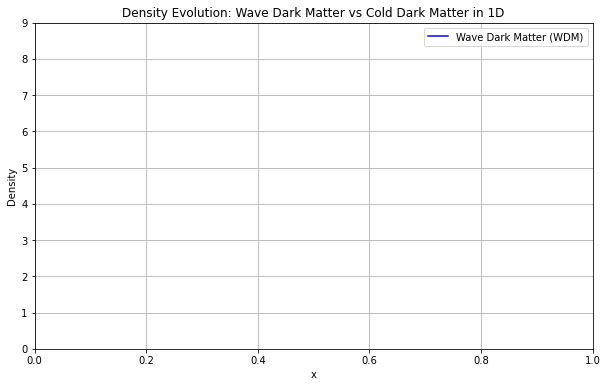

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft


# Poisson solver (1D FFT)
def poisson_solver(rho):
    #k = 2 * np.pi/8.0 * np.fft.fftfreq(N, d=dx)
    rho_k = np.fft.fftn(rho-1.0)
    phi_k = - rho_k / (k**2 + (k==0))  # Small term to avoid division by zero
    phi = np.fft.ifftn(phi_k).real
    return phi

import matplotlib.animation as animation
%matplotlib inline

# Adding small diffusion to CDM to stabilize and prevent overflow
epsilon = 0.01  # Small diffusion constant to stabilize CDM evolution

# Constants and parameters
hbar = 1.0  # Reduced Planck constant (for simplicity)
G = 1.0     # Gravitational constant (for simplicity)
m_wdm = 1.0#e-7 # Mass of wave dark matter particle
dx = 8./150.#0.01    # Spatial resolution
dt = np.pi/100#0.04   # Time step
L = 8.0    # Length of the 1D box
N = int(L / dx)  # Number of grid points
x = np.linspace(0,L,N)#np.linspace(-L/2, L/2, N)  # Spatial grid
timesteps = 150  # Number of time steps

# Initial conditions for wave dark matter (WDM)
psi = (1.0+0.6*np.sin(2*np.pi * x / L))**0.5 + 1j * np.zeros_like(x)#np.exp(-x**2) + 1j * np.zeros_like(x)  # Initial wave function
rho_wdm = np.abs(psi)**2  #* M_cdm  # CDM mass scaling# Density for WDM


k = 2 * np.pi/L * np.fft.ifftshift(np.arange(-N/2,N/2))#np.fft.ifftshift(np.fft.fftfreq(N, d=dx))
# # CDM density profile (classical collapse)
# def rho_cdm(x):
#   return np.exp(-((x - L / 2) ** 2) / (2 * (L / 10) ** 2))

# FCDM density profile (with Jeans scale suppression)
def rho_fcdm(x,rho):
  #rho = np.exp(-((x - L / 2) ** 2) / (2 * (L / 10) ** 2))
  # Apply Jeans scale smoothing (Fourier filtering)
  #k = np.fft.fftfreq(N, dx) * 2 * np.pi
  rho_k = np.fft.fftn(rho)
  rho_k[np.abs(k) > kJ] = 0  # Suppress high k modes (small scales)
  return np.fft.ifftn(rho_k).real

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(10, 6))
line_wdm, = ax.plot([], [], label='Wave Dark Matter (WDM)', color='blue')
#line_cdm, = ax.plot([], [], label='Cold Dark Matter (CDM)', color='red', linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 2*4.5)
ax.set_title("Density Evolution: Wave Dark Matter vs Cold Dark Matter in 1D")
ax.set_xlabel("x")
ax.set_ylabel("Density")
ax.legend()
ax.grid(True)

V = poisson_solver(np.abs(psi)**2)
# Initialization function for the animation
def init():
  line_wdm.set_data([], [])
  #line_cdm.set_data([], [])
  return [line_wdm]#, line_cdm
data = []
# Update function for the animation
def update(frame):
  global psi, rho_wdm#, rho_cdm, v_cdm

  #print(frame)
  # WDM evolution (Schrodinger equation)
  # (1/2) kick
  #psi = np.exp(-1.j*dt/2.0*V) * psi

  psi_k = fft(psi)
  #print(psi)
  psi_k *= np.exp(-1j * hbar * (k**2) * dt / (2 * m_wdm))
  #print(psi_k)
  psi = ifft(psi_k)
  #print(psi)
  phi_wdm = poisson_solver(np.abs(psi)**2)
  #print(phi_wdm)
  psi *= np.exp(-1j * m_wdm * phi_wdm * dt / hbar)
  #print(psi)
  #psi[0] = 1.0+0.0j
  #psi[-1] = 1.0+0.0j
  rho_wdm = np.abs(psi)**2  # Update WDM density
  data.append(rho_wdm)
  #rho_wdm = rho_fcdm(x,rho_wdm)

  # Update the plot
  line_wdm.set_data(x/L, rho_wdm)#rho_fcdm(x,rho_wdm))#rho_wdm)
  #line_cdm.set_data(x/L, rho_cdm)
  return [line_wdm]#, line_cdm


# Create the animation
ani = animation.FuncAnimation(fig, update, frames=timesteps, init_func=init, blit=True, interval=50)

# Display the animation
#plt.close(fig)  # Prevent duplicate display of the static plot
ani


In [24]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [25]:
time_list = np.arange(0, timesteps * dt, dt)

In [26]:
len(time_list)

150

In [27]:
len(x)

150

150.00000000000009
150.00000000000045
150.00000000000068
150.00000000000057
150.00000000000026
150.00000000000014
150.00000000000009
149.99999999999986
149.9999999999998
149.99999999999986


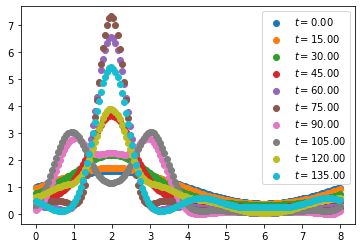

In [29]:
#time_indices = [i for i in range(0,len(data),15)]
# Use a colormap for the rainbow effect
cmap = plt.cm.rainbow
colors = cmap(np.linspace(0, 1, len(time_indices)))
for idx in range(0,len(time_list),15):#range(0,len(data),15):
    plt.scatter(x,data[idx],label=f"$t = {idx:.2f}$")
    print(np.sum(data[idx]))
plt.legend()

In [39]:
(torch.ones((150, 1))*x.reshape((150,1)).astype('float32')).dtype

torch.float32

In [36]:
x.reshape((150,1)).dtype

dtype('float64')

In [37]:
torch.ones((150, 1)).dtype

torch.float32

In [22]:
V_l_boundary = net(xl_boundary,t_boundary)[:,2]#**2+net(xl_boundary,t_boundary)[:,1]**2
V_l_boundary.shape

V_r_boundary = net(xr_boundary,t_boundary)[:,2]#**2+net(xl_boundary,t_boundary)[:,1]**2#net(xr_boundary,t_boundary)[:,1]
V_r_boundary.shape

torch.Size([10000])

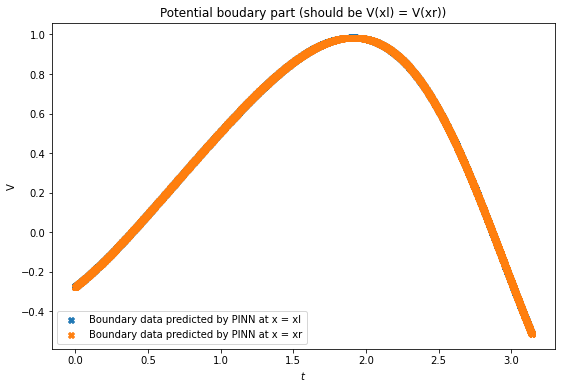

In [23]:

fig = plt.figure(figsize=(9,6))
plt.title('Potential boudary part (should be V(xl) = V(xr))')
plt.scatter(t_boundary, V_l_boundary.detach().numpy(),  marker='X', label="Boundary data predicted by PINN at x = xl")
plt.scatter(t_boundary, V_r_boundary.detach().numpy(),  marker='X', label="Boundary data predicted by PINN at x = xr")
plt.xlabel('$t$')
plt.ylabel('V')#
plt.legend()
plt.show()
plt.close()

In [15]:
psi_initial_pred = net(x_initial,t_initial)[:,0:2]
psi_initial_pred.shape

torch.Size([10000, 2])

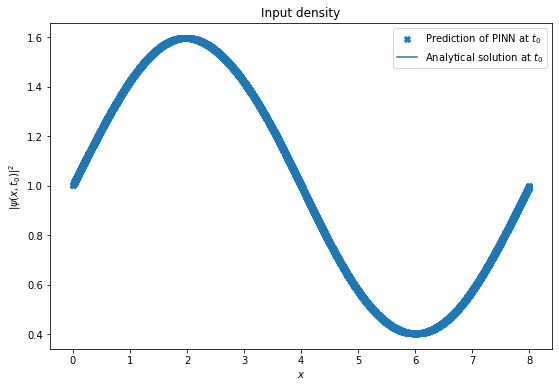

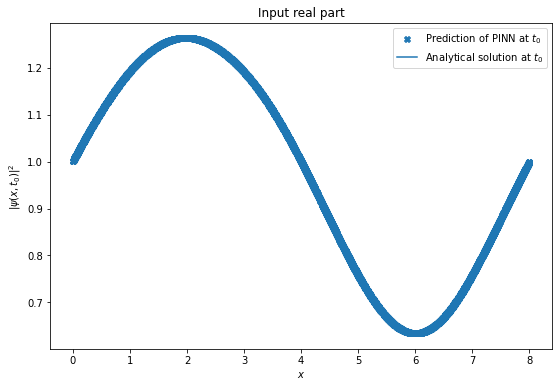

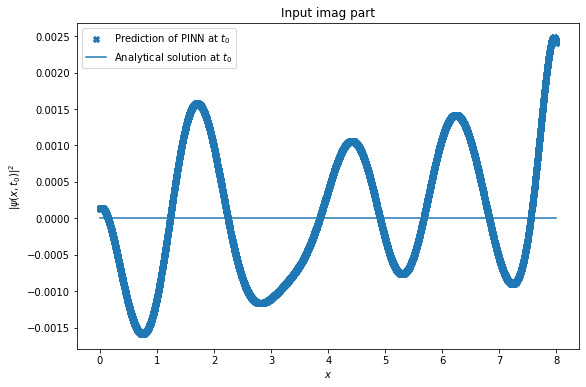

NameError: name 'V_init_pred' is not defined

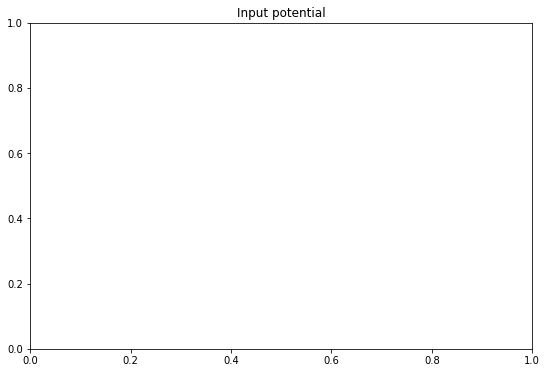

In [16]:
fig = plt.figure(figsize=(9,6))
plt.title('Input density')
plt.scatter(x_initial, get_density(psi_initial_pred).detach().numpy(),  marker='X', label="Prediction of PINN at $t_0$")
plt.plot(x_linear, get_density(psi_0_linear), label=r"Analytical solution at $t_0$")
#plt.ylim(0, 2)
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Input real part')
plt.scatter(x_initial, get_real(psi_initial_pred).detach().numpy(),  marker='X', label="Prediction of PINN at $t_0$")
plt.plot(x_linear, get_real(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Input imag part')
plt.scatter(x_initial, get_imag(psi_initial_pred).detach().numpy(),  marker='X', label="Prediction of PINN at $t_0$")
plt.plot(x_linear, get_imag(psi_0_linear), label=r"Analytical solution at $t_0$")
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(9,6))
plt.title('Input potential')
plt.scatter(x_initial, (V_init_pred),  marker='X', label="Prediction of PINN at $t_0$")
plt.scatter(x_initial, V_init, label=r"Analytical solution at $t_0$")
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t_0)|^2$')#
plt.legend()
plt.show()
plt.close()